# Configuring KSVC with Benchmarks
This notebook will walk you through running benchmarks against your inference server and using this data to configure a Knative service to properly autoscale your inference services.

## Prerequisites

### KSVC Template

The main requirement for running these benchmarks is creating your ksvc template.

To create your own template, you need to provide a container image that runs your inference server and model of choice. The container should take care of creating an [OpenAI-like Chat completion API](https://platform.openai.com/docs/api-reference/chat/create) as the benchmarks will use the OpenAI python library to interact with the service.

All the following can be run "out of the box" using the example ksvc template: `ksvc-template-mistral.yaml`. This examples runs the Mistral-7B Instruct finetune using vLLM. This features an OpenAI-like API, and various inference optimizations like continuous batching and paged attention.

The benchmarks require that the ksvc template yaml have the following python format variables, so it can programmatically alter them:
 - name
 - annotations
 - container_concurrency
 - timeout_seconds

### kubectl Configuration

The benchmark code will run `kubectl` commands to interact with the Knative services. Before running the benchmarks, you should verify that your local `kubectl` is configured to interact with access to CoreWeave Kubernetes.

In [1]:
# Uncomment and run to verify that kubectl is properly configured
# !kubectl get pods

### Dataset

The benchmark requires a dataset that will be used as requests to send to the Knative services.

As will be discussed later, it is important that the dataset be representative of the requests that will be run through your inference services in production.

If you do not have a dataset, you can run the following cell to download the ShareGPT dataset from HuggingFace.

In [2]:
# Uncomment and run if a dataset is needed
# !wget https://huggingface.co/datasets/anon8231489123/ShareGPT_Vicuna_unfiltered/resolve/main/ShareGPT_V3_unfiltered_cleaned_split.json

## Single Server Benchmarking

The first step is to analyze the performance of a single inference server. How an inference server handles different levels of concurrent requests will inform our target concurrencies and how quickly we need to autoscale.

In these benchmarks, we will adjust the number of concurrent requests that are sent to a single inference server and see how this impacts per request latency and throughput of the server.

### Batching

Before running these benchmarks, you need to determine if your inference server code properly handles batching. The rest of this notebook assumes that your inference server a strategy called "continuous batching". Note that it is also called "in-flight batching" or "iteration-level batching". This means that your inference server can batch a dynamic number of requests together at each pass of the model. Adding and removing requests from the batch if new inputs are received or outputs finish generating.

### Latency vs Throughput Tradeoff

With continuous batching, you are able to greatly increase the total throughput of your inference server by batching large numbers of requests. However, this will impact the per request latency. From the results of these benchmarks, you will be able to decide what level of per-request latency drop you are willing to accept for an increase in total system throughput.

### KV Cache Bottleneck

The total batch size that your inference server can handle is largely limited by the GPU memory you have available for the KV Cache. Optimizations like Paged Attention can greatly reduce the memory required for each request, but you will still see a large drop in performance should the KV Cache fill up and CPU offload is needed.

Therefore, you should make sure that the container concurrencies you test are able to utilize the KV Cache without filling it up. In this example, vLLM is used which provides logging around the KV Cache usage at 5 second intervals.

Input and output lengths of requests, and sampling parameters can have a large impact on the KV Cache usage. If your requests have a very large context, then that will lead to more KV Cache usage per request. If you change the sampling parameters of your requests to return more chat completions or use advanced strategies like beam search, that can also increase the KV Cache usage of each request.

This is why it is important to use a dataset that is representative of the requests that will be used in production, along with sampling parameters that reflect production usage.

In [6]:
# Adjust the following values as needed

dataset = "examples/ShareGPT_V3_unfiltered_cleaned_split.json"
tokenizer = "mistralai/Mistral-7B-Instruct-v0.1"
ksvc_template = "examples/ksvc-template-mistral.yaml"
n_requests = 25  # TODO: Increase this
n_sampling = 1
output = "concurrency_test_nb.pkl"

concurrencies = [1, 5, 10, 20, 30, 40, 50, 60, 70]

In [7]:
from test_concurrency import test_req_levels, plot_concur_req_results
from data import sample_requests

In [5]:
# Process the dataset
requests = sample_requests(dataset, n_requests, tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Tokenizing the dataset...
Filtering the dataset...


In [11]:
results = await test_req_levels(concurrencies,
                                requests,
                                ksvc_template,
                                file_name=output,
                                n_sampling=n_sampling)

service.serving.knative.dev/concur-req-1-74138 created
service.serving.knative.dev/concur-req-5-18166 created
service.serving.knative.dev/concur-req-10-28488 created
service.serving.knative.dev/concur-req-20-94295 created
service.serving.knative.dev/concur-req-30-36983 created
service.serving.knative.dev/concur-req-40-78869 created
service.serving.knative.dev/concur-req-50-31073 created
service.serving.knative.dev/concur-req-60-50260 created
service.serving.knative.dev/concur-req-70-66320 created
Startup time: 52.86s


1 concurrent requests:   0%|          | 0/25 [00:00<?, ?it/s]

Startup time: 51.12s


20 concurrent requests:   0%|          | 0/500 [00:00<?, ?it/s]

Startup time: 47.85s


50 concurrent requests:   0%|          | 0/1250 [00:00<?, ?it/s]

Startup time: 51.97s


40 concurrent requests:   0%|          | 0/1000 [00:00<?, ?it/s]

Startup time: 72.23s


30 concurrent requests:   0%|          | 0/750 [00:00<?, ?it/s]

Startup time: 76.93s


10 concurrent requests:   0%|          | 0/250 [00:00<?, ?it/s]

Startup time: 72.98s


60 concurrent requests:   0%|          | 0/1500 [00:00<?, ?it/s]

Startup time: 79.59s


70 concurrent requests:   0%|          | 0/1750 [00:00<?, ?it/s]

Startup time: 105.58s


5 concurrent requests:   0%|          | 0/125 [00:00<?, ?it/s]

service.serving.knative.dev "concur-req-1-74138" deleted
service.serving.knative.dev "concur-req-10-28488" deleted
service.serving.knative.dev "concur-req-20-94295" deleted
service.serving.knative.dev "concur-req-5-18166" deleted
service.serving.knative.dev "concur-req-30-36983" deleted
service.serving.knative.dev "concur-req-40-78869" deleted
service.serving.knative.dev "concur-req-50-31073" deleted
service.serving.knative.dev "concur-req-60-50260" deleted
service.serving.knative.dev "concur-req-70-66320" deleted


### Analyzing the results

The raw data is plotted a number of different ways below.

There are a number of different patterns, but the most important takeaway is that you can increase total system throughput with more concurrent requests, but there will be a penalty to per-request latency.

### Per Request Latencies

The first row of the graphs below are representing the performance of individual requests. Here the y-axis is the end to end latency, but normalized for the varying lengths of responses and therefore is shown as tokens per second. Note that the tokens used in this calculation includes both the prompt and generated tokens. There will be a difference as the ratio of input to output tokens varies, but that is another reason why using a representative dataset is important.

First, notice that the latencies for 1 concurrent request represent a lower bound for the performance for your model, inference server, and hardware combo. There are no other requests competing for resources.

As you increase the number of concurrent requests, the per-iteration batch size is increasing and on average the KV Cache usage is increasing. This increases the per-request latency as you can see, but by much less than the amount you are increasing the concurrent requests. This is the power of continuous batching and paged attention making the most of available KV Cache.

### Time to First Token

For inference services that stream response tokens back to the end users as they are generated, time to first token is an important metric to consider as it can greatly impact the user experience.

Time to first token (TTFT) represents the time spent in any sort of queue, the first forward pass through the input context, and the first forward pass to generate the first token.

### System Throughput

The first chart in the final row graphs the total system throughput. In an ideal world, you wouldn't see any slow down per-request as you increase the concurrent requests and the throughput of 70 concurrent requests would be 70 times as big as the throughput of a single request.

As you can see, this ideal linear scaling does not happen, but you can squeeze a lot more usage out of your single inference server by increasing the concurrent requests.

### Per-Request Latency vs Total Throughput

The final chart is showing the tradeoff between per-request and system performance. In this chart, top left would be ideal and bottom right would be the worst.

While you can get much better system throughput, the per-request latency increases.

Different services might belong on different points of this request latency vs system throughput curve. If you have an abundance of compute and care highly of each requests latency, then target a lower number of concurrent requests. If you would like to get as much performance per GPU as possible, and can take a hit per request, then increase the number of concurrent requests.


In [6]:
# Reload results if needed
# import pickle
#
# with open(output, "rb") as file:
#     results = pickle.load(file)

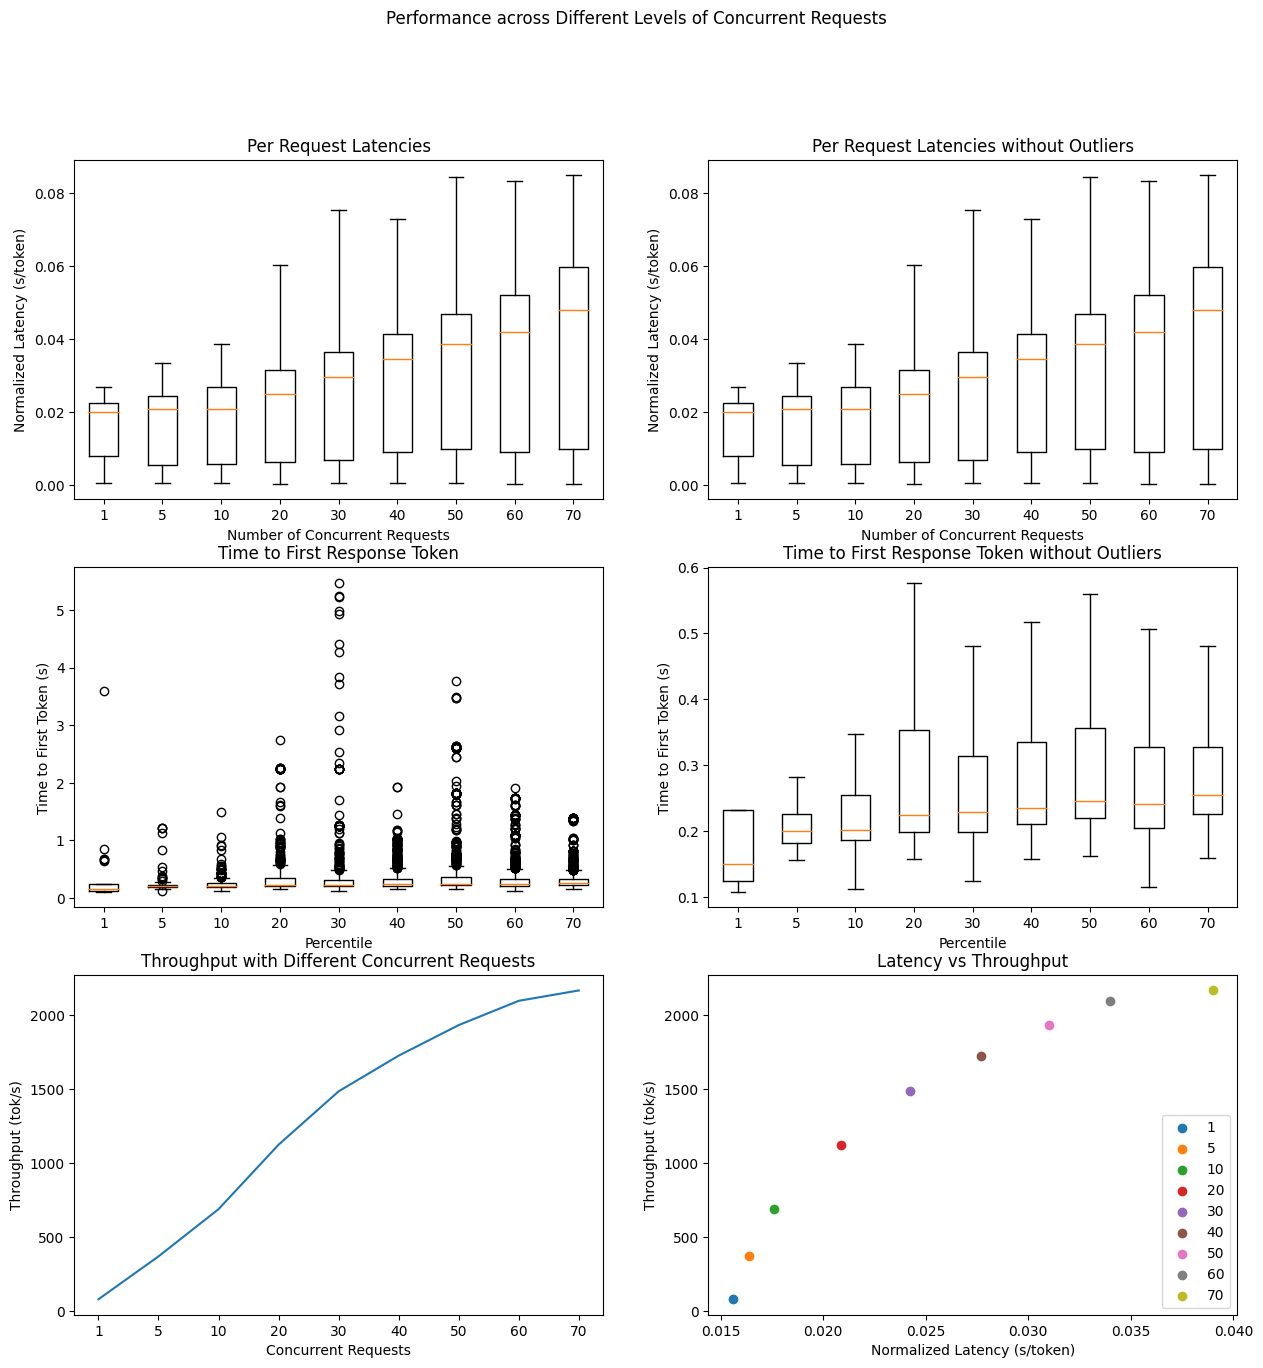

In [7]:
plot_concur_req_results(results=results)

## Autoscaling Benchmarking

The following benchmarks will build on the single server benchmarks to get the best performance out of the inference service as scale as production traffic changes.

### Pod Start up Times

The amount of time it takes to get a new pod ready to start accepting requests after Knative decides to scale up is an important value to know that will be used to derive many Knative scaling parameters.

The total pod startup time is determined by two pieces: container start up, and inference server start up. The container startup involves downloading (if not cached), deserializing, and starting a container image.

Inference server start up is largely determined by how long it takes to load your model onto the GPU. Using CoreWeave's Tensorizer can greatly reduce the model load time.

One important thing to note is that CoreWeave Kubernetes leverages automatic docker image caching. Therefore, if you are using a new image for the first time, you will see longer startup times. To account for this, it is recommended to use a max concurrency that is less than total deployments to mirror the behavior of an inference service scaling up and down over time.

In [2]:
from test_startup_time import run_startup_test

/home/npratt/git/kubernetes-cloud/online-inference/kbench/test_startup_time.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# TODO: Increase these values as needed
n_trials = 3
max_concurrent = 1

In [4]:
avg_time = await run_startup_test(ksvc_template, n_trials, max_concurrent)
print(f"Average startup time: {avg_time:.2f}s")

Testing startup time:   0%|          | 0/3 [00:00<?, ?it/s]

Average startup time: 46.38s


With an average pod startup time of about 45 seconds, we can then use this value to determine things like the size of the stable and panic windows. In theory, we want Knative to take the pod startup time into account when making autoscaling decisions.

### Target vs Container Concurrency

Knative has both a soft and hard limit on concurrency, and then a separate target concurrency. You can use either a soft or hard limit, and with continuous batching it is recommended to set a hard limit between your desired concurrency and the amount of requests that fit in the KV Cache. (The desired concurrency comes from the single inference server benchmarks)

Since continuous batching means the inference server can support a wide range of concurrent requests as shown in the previous benchmark, this means that it is possible for pods to handle a quick burst over their desired concurrency. However, if the hard limit is too high above the desired concurrency, when there is a large increase in traffic then the older pods will have a large backlog of requests while fresh pods are below the desired concurrencies.

If requests are being buffered by the Knative activators, then they can spread out the large number of pending requests to new pods as they come up from autoscaling events.

This benchmark will create multiple inference services and send requests and a varying rate to see how they respond to these increases and decreases in traffic. The hard limit on concurrency will be varied, while the target concurrency will stay consistent at 30 requests.

In [5]:
n_requests = 10_000
container_concurrencies = [30, 40, 50, 60, 70]
target_concurrency = 30
base_request_rate = 1
max_request_multiplier = 10
rate_variation_period = n_requests
output = "concurrency_test_nb.pkl"

In [8]:
requests = sample_requests(dataset, n_requests, tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Tokenizing the dataset...
Filtering the dataset...


In [11]:
from test_scaling_concurrency import run_container_concurreny_experiment, plot_all_scaling_latencies

In [ ]:
results = await run_container_concurreny_experiment(
    requests,
    target_concurrency,
    container_concurrencies,
    base_request_rate,
    max_request_multiplier,
    rate_variation_period,
    ksvc_template,
    file_name=output,
)

### Analyzing the Results

In the background of every chart, you will see a histogram in gray representing the amount of requests sent in that respective timeframe. In this test there was a single increase and decrease from 1 request per second to 10 requests per second. Each of the lines on the chart represent a 2 min rolling average of a different percentile of per-request latency. Then each chart represents a different hard concurrency limit.

At one of the spectrum, you can see that a hard limit matching the target concurrency of 30 requests leads to a large increase in latency as traffic increases. This is because Knative is buffering requests until new pods start up.

As the hard limit increases, we see that the spike of latency correlating to the increase in traffic decreases from a combination of each inference server handling a larger concurrent requests and Knative autoscaling and increasing the number of active pods.

Then at the other end of the specturm, at a hard limit of 70 concurrent requests, we see the latency spike start to reappear. This happens because the original pods build up a large number of concurrent requests (pod queue depth) and when a new pod comes online from a Knative scaling request, many of the requests are "stuck" in these overloaded pods.

In [9]:
# Reload the data from disk if needed
# import pickle
#
# with open("./examples/scaling_test.pkl", "rb") as f:
#     results = pickle.load(f)

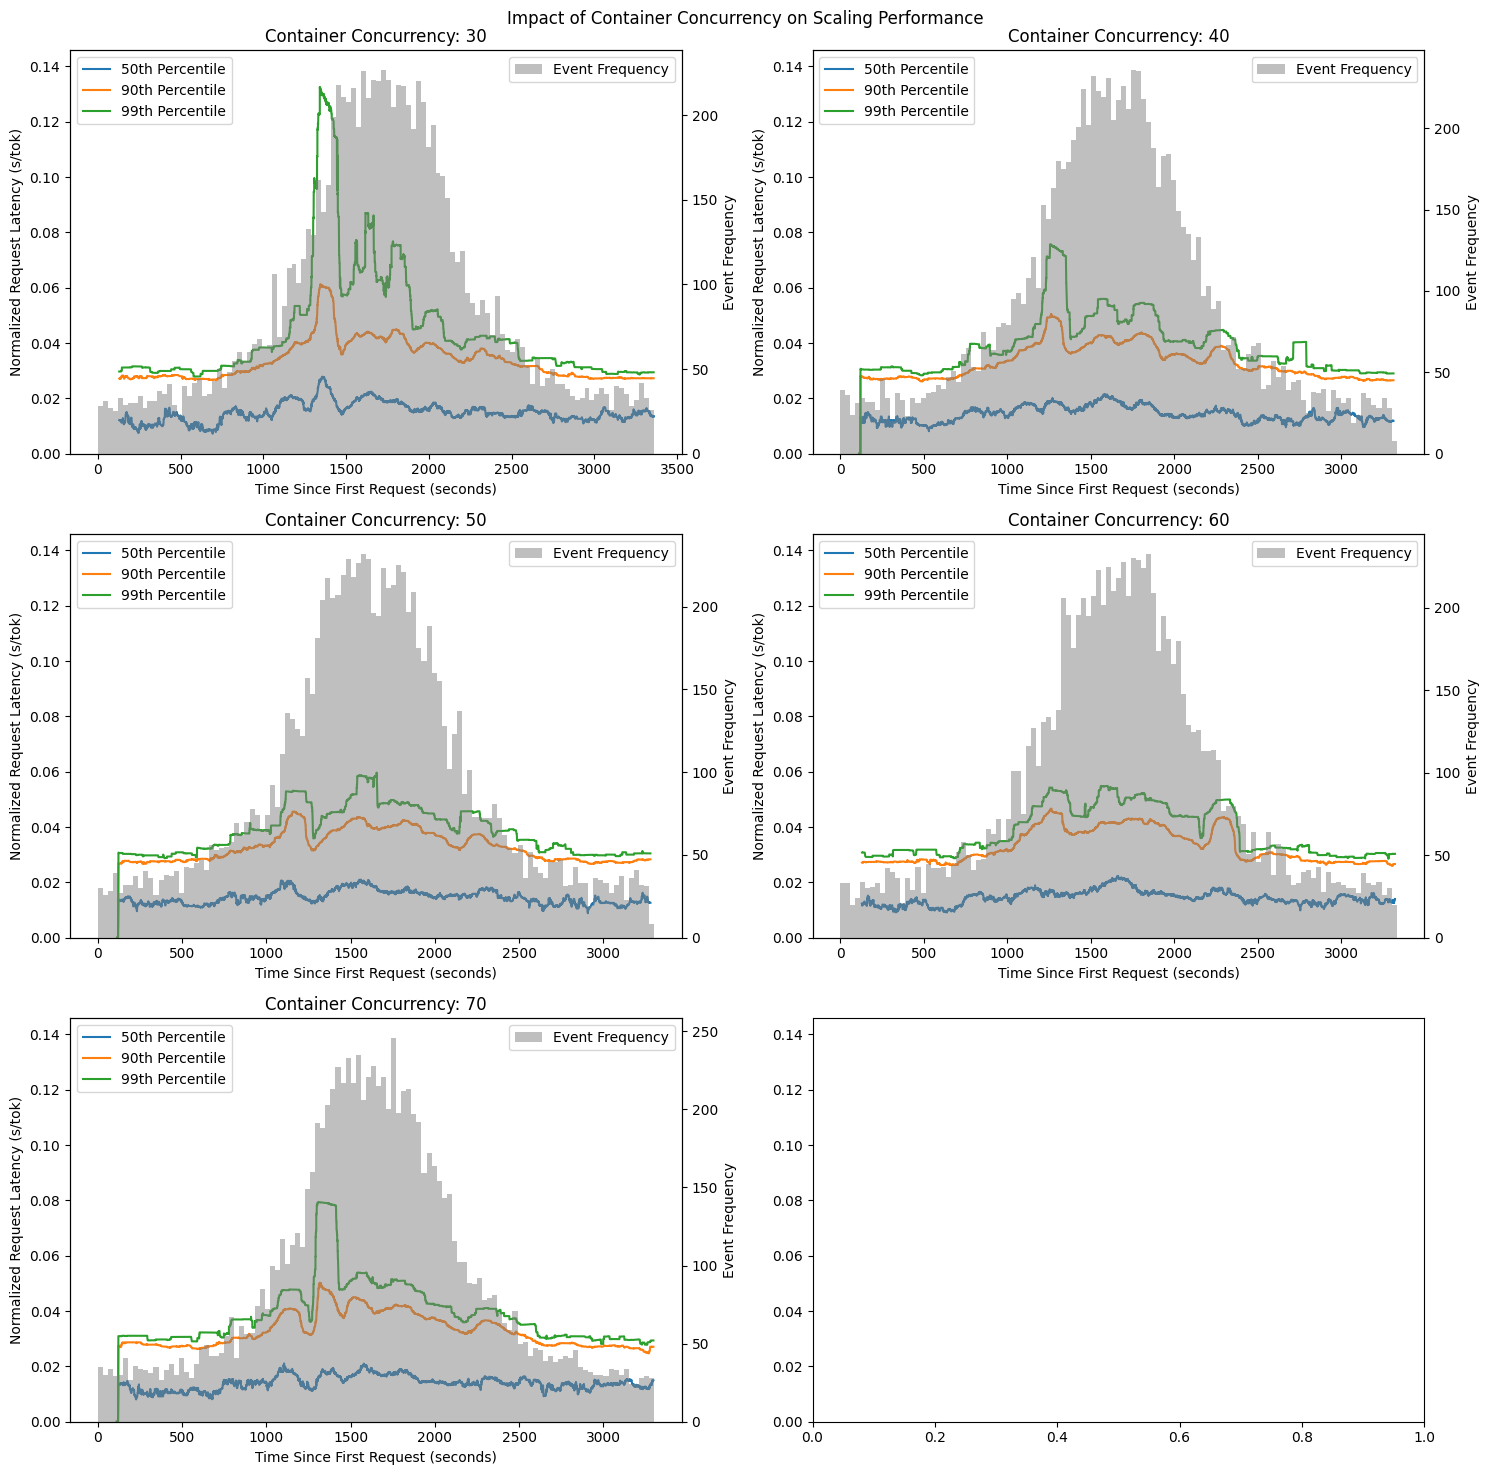

In [12]:
plot_all_scaling_latencies(results, percentiles=[50, 90, 99])